# 💭🧠🤍 Custom NER model for mental health purposes 🖤🧠💭

## Installing all necessary libraries and packages

In [7]:
pip install spacy -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
!python -m spacy download en_core_web_sm en_core_web_lg -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [98]:
# default libraries
import json
import os
import random
import re
import subprocess

# installed libraries
from matplotlib import pyplot
import numpy
import requests
from sklearn.metrics import confusion_matrix
import spacy
from spacy import displacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy.training import offsets_to_biluo_tags
from tqdm import tqdm
import warnings

# local libraries
%reload_ext autoreload
%autoreload 2
import datahelper as dt
import evaluation as ev

## Exploring performance of generalized spaCy models

Many 

In [28]:
test="""After a decades-long pause, psychedelics are again being intensely investigated for treating a wide range of 
        neuropsychiatric ailments including depression, anxiety, addiction, post-traumatic stress disorder, anorexia, 
        and chronic pain syndromes. The classic serotonergic psychedelics psilocybin and lysergic acid diethylamide and 
        nonclassic psychedelics 3,4-methylenedioxymethamphetamine and ketamine are increasingly appreciated as neuroplastogens 
        given their potential to fundamentally alter mood and behavior well beyond the time window of measurable exposure. 
        Imaging studies with psychedelics are also helping advance our understanding of neural networks and connectomics. 
        This resurgence in psychedelic science and psychedelic-assisted therapy has potential significance for the fields of 
        neurosurgery and neuro-oncology and their diverse and challenging patients, many of whom continue to have mental health 
        issues and poor quality of life despite receiving state-of-the-art care. In this study, we review recent and ongoing 
        clinical trials, the set and setting model of psychedelic-assisted therapy, potential risks and adverse events, proposed 
        mechanisms of action, and provide a perspective on how the safe and evidence-based use of psychedelics could potentially 
        benefit many patients, including those with brain tumors, pain syndromes, ruminative disorders, stroke, SAH, TBI, and 
        movement disorders. By leveraging psychedelics' neuroplastic potential to rehabilitate the mind and brain, novel 
        treatments may be possible for many of these patient populations, in some instances working synergistically with current 
        treatments and in some using subpsychedelic doses that do not require mind-altering effects for efficacy. This review aims 
        to encourage broader multidisciplinary collaboration across the neurosciences to explore and help realize the transdiagnostic 
        healing potential of psychedelics."""
test = re.sub("[\n ]+", " ", test)

### Small English Model

In [18]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(test)
displacy.render(doc, style="ent", jupyter=True)

### Large English Model

In [19]:
nlp = spacy.load("en_core_web_lg")
doc = nlp(test)
displacy.render(doc, style="ent", jupyter=True)

### Conclusion
We can clearly see that neither small nor large spacy models was not able to catch any entities from the provided abstract correctly. It is not surprising since these are very generalized english models and therefore they are not traind on a specific set of biological data. Most likely this model has never seen anything like this abstract before. Moreover, as we can see below, our model doesn't even posess the labels that we want. Thus, we will explore some other models and the ways to customize a model according to our needs.

In [27]:
for pipe_name in nlp.pipe_names:
    if pipe_name == 'ner':
        component = nlp.get_pipe(pipe_name)
        if hasattr(component, "labels"):
            print(component.labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


## Creating a custom model

In [5]:
!python -m spacy init fill-config model/base_config.cfg model/config.cfg

[+] Auto-filled config with all values
[+] Saved config
model\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [7]:
!python -m spacy train model/config.cfg --output ./model --paths.train data/train.spacy --paths.dev data/test.spacy

[i] Saving to output directory: model
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    103.26    0.00    0.00    0.00    0.00
  0     200       1200.97   4340.73   75.87   80.48   71.75    0.76
  1     400       1728.53   1328.53   78.09   83.86   73.06    0.78
  1     600       3768.87   1504.50   82.40   85.03   79.92    0.82
  2     800        167.95    741.77   84.91   86.19   83.67    0.85
  3    1000        213.96    564.77   85.18   86.30   84.09    0.85
  3    1200        144.10    448.37   86.99   88.38   85.64    0.87
  4    1400       1880.44    523.65   86.42   87.34   85.52    0.86
  4    1600       7132

[2023-03-28 20:07:25,957] [INFO] Set up nlp object from config
[2023-03-28 20:07:25,975] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-03-28 20:07:25,981] [INFO] Created vocabulary
[2023-03-28 20:07:25,983] [INFO] Finished initializing nlp object
[2023-03-28 20:07:28,786] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


In [78]:
nlp = spacy.load("./model/model-best")

In [11]:
test = """The PAWS Study used an online platform to deliver a cross-sectional survey instrument designed to assess participants' 
        retrospective perspectives on the mental health effects of classic psychedelic use, as well as predictors of positive and 
        negative outcomes from this use. Because of our focus on classic psychedelic agents (i.e., tryptamines and phenethylamines 
        with a primary mechanism of action believed to be agonism of the serotonin 5HT2A receptor), we did not query 
        3,4-Methylenedioxymethamphetamine (MDMA), which has a different mechanism of action and tends to produce different acute 
        effects than classic psychedelics. Given the widespread emerging use of ketamine as a “psychedelic-like” agent for the 
        treatment of major depressive disorder, we included this agent in our survey, although we recognize that it is not a 
        classic psychedelic."""
test = re.sub("[\n ]+", " ", test)

In [12]:
doc = nlp(test)

In [13]:
options = dt.pretty_colors()
spacy.displacy.render(doc, style="ent", jupyter=True, options=options)

In [14]:
test = """Major depressive disorder (MDD) is a substantial public health burden, but current treatments have limited 
        effectiveness and adherence. Recent evidence suggests that 1 or 2 administrations of psilocybin with psychological 
        support produces antidepressant effects in patients with cancer and in those with treatment-resistant depression.
        This randomized, waiting list–controlled clinical trial was conducted at the Center for Psychedelic and Consciousness 
        Research at Johns Hopkins Bayview Medical Center in Baltimore, Maryland. Adults aged 21 to 75 years with an MDD diagnosis, 
        not currently using antidepressant medications, and without histories of psychotic disorder, serious suicide attempt, or 
        hospitalization were eligible to participate. Enrollment occurred between August 2017 and April 2019, and the 4-week primary 
        outcome assessments were completed in July 2019. A total of 27 participants were randomized to an immediate treatment condition 
        group (n = 15) or delayed treatment condition group (waiting list control condition; n = 12). Data analysis was conducted from 
        July 1, 2019, to July 31, 2020, and included participants who completed the intervention (evaluable population)."""
test = re.sub("[\n ]+", " ", test)

In [15]:
doc = nlp(test)
options = dt.pretty_colors()
spacy.displacy.render(doc, style="ent", jupyter=True, options=options)

In [18]:
test = """Most of the current pharmacotherapies for MDD, including the widely used selective serotonin reuptake inhibitors, increase levels 
        of brain monoamine neurotransmitters such as serotonin and norepinephrine (typically by blocking reuptake). A growing body of evidence 
        suggests that newer ketamine-like medications exert therapeutic efficacy in MDD through effects on glutamate neurotransmission.
        Ketamine hydrochloride, a nonselective N-methyl-d-aspartate receptor antagonist, is the most well-researched of these newer 
        medications. Several studies have demonstrated the efficacy of a single ketamine infusion in rapidly (within hours) reducing depression 
        symptoms and, when effective, lasting from a few days to about 2 weeks. However, ketamine has high abuse liability, and its 
        administration involves moderate physiological risk that requires medical monitoring."""
test = re.sub("[\n ]+", " ", test)

In [19]:
doc = nlp(test)
options = dt.pretty_colors()
spacy.displacy.render(doc, style="ent", jupyter=True, options=options)

In [24]:
docs = dt.load_data("data/test_data.json")["annotations"]
print (docs[10])

['Det er okt interesse for psykedeliske stoffer til bruk i behandling av psykiske lidelser. Stoffene regnes som trygge nar de gis innenfor en klinisk ramme. Eldre studier fra for 1970 har metodologiske svakheter, men i de senere ar har det kommet lovende resultater fra bruk ved unipolar depresjon, depresjon ved livstruende sykdom, angst og avhengighet. Formalet med denne litteraturgjennomgangen er a gi en oversikt over nyere resultater og disse studienes begrensninger. Vi sokte i databasen PubMed etter kliniske studier fra perioden 1990-2017 med sokeordene angst, depresjon, avhengighet og psykedeliske stoffer. Kvaliteten pa studiene ble sa vurdert ut ifra metode og styrkeberegning. Soket ga 424 artikler, hvorav ni ble inkludert (fire om angst og depresjon ved livstruende sykdom, to om depresjon, to om avhengighetslidelse og en om tvangslidelse). To dobbeltblinde, randomiserte, kontrollerte fase II-studier med et moderat antall pasienter fant umiddelbar, markert og vedvarende effekt av 

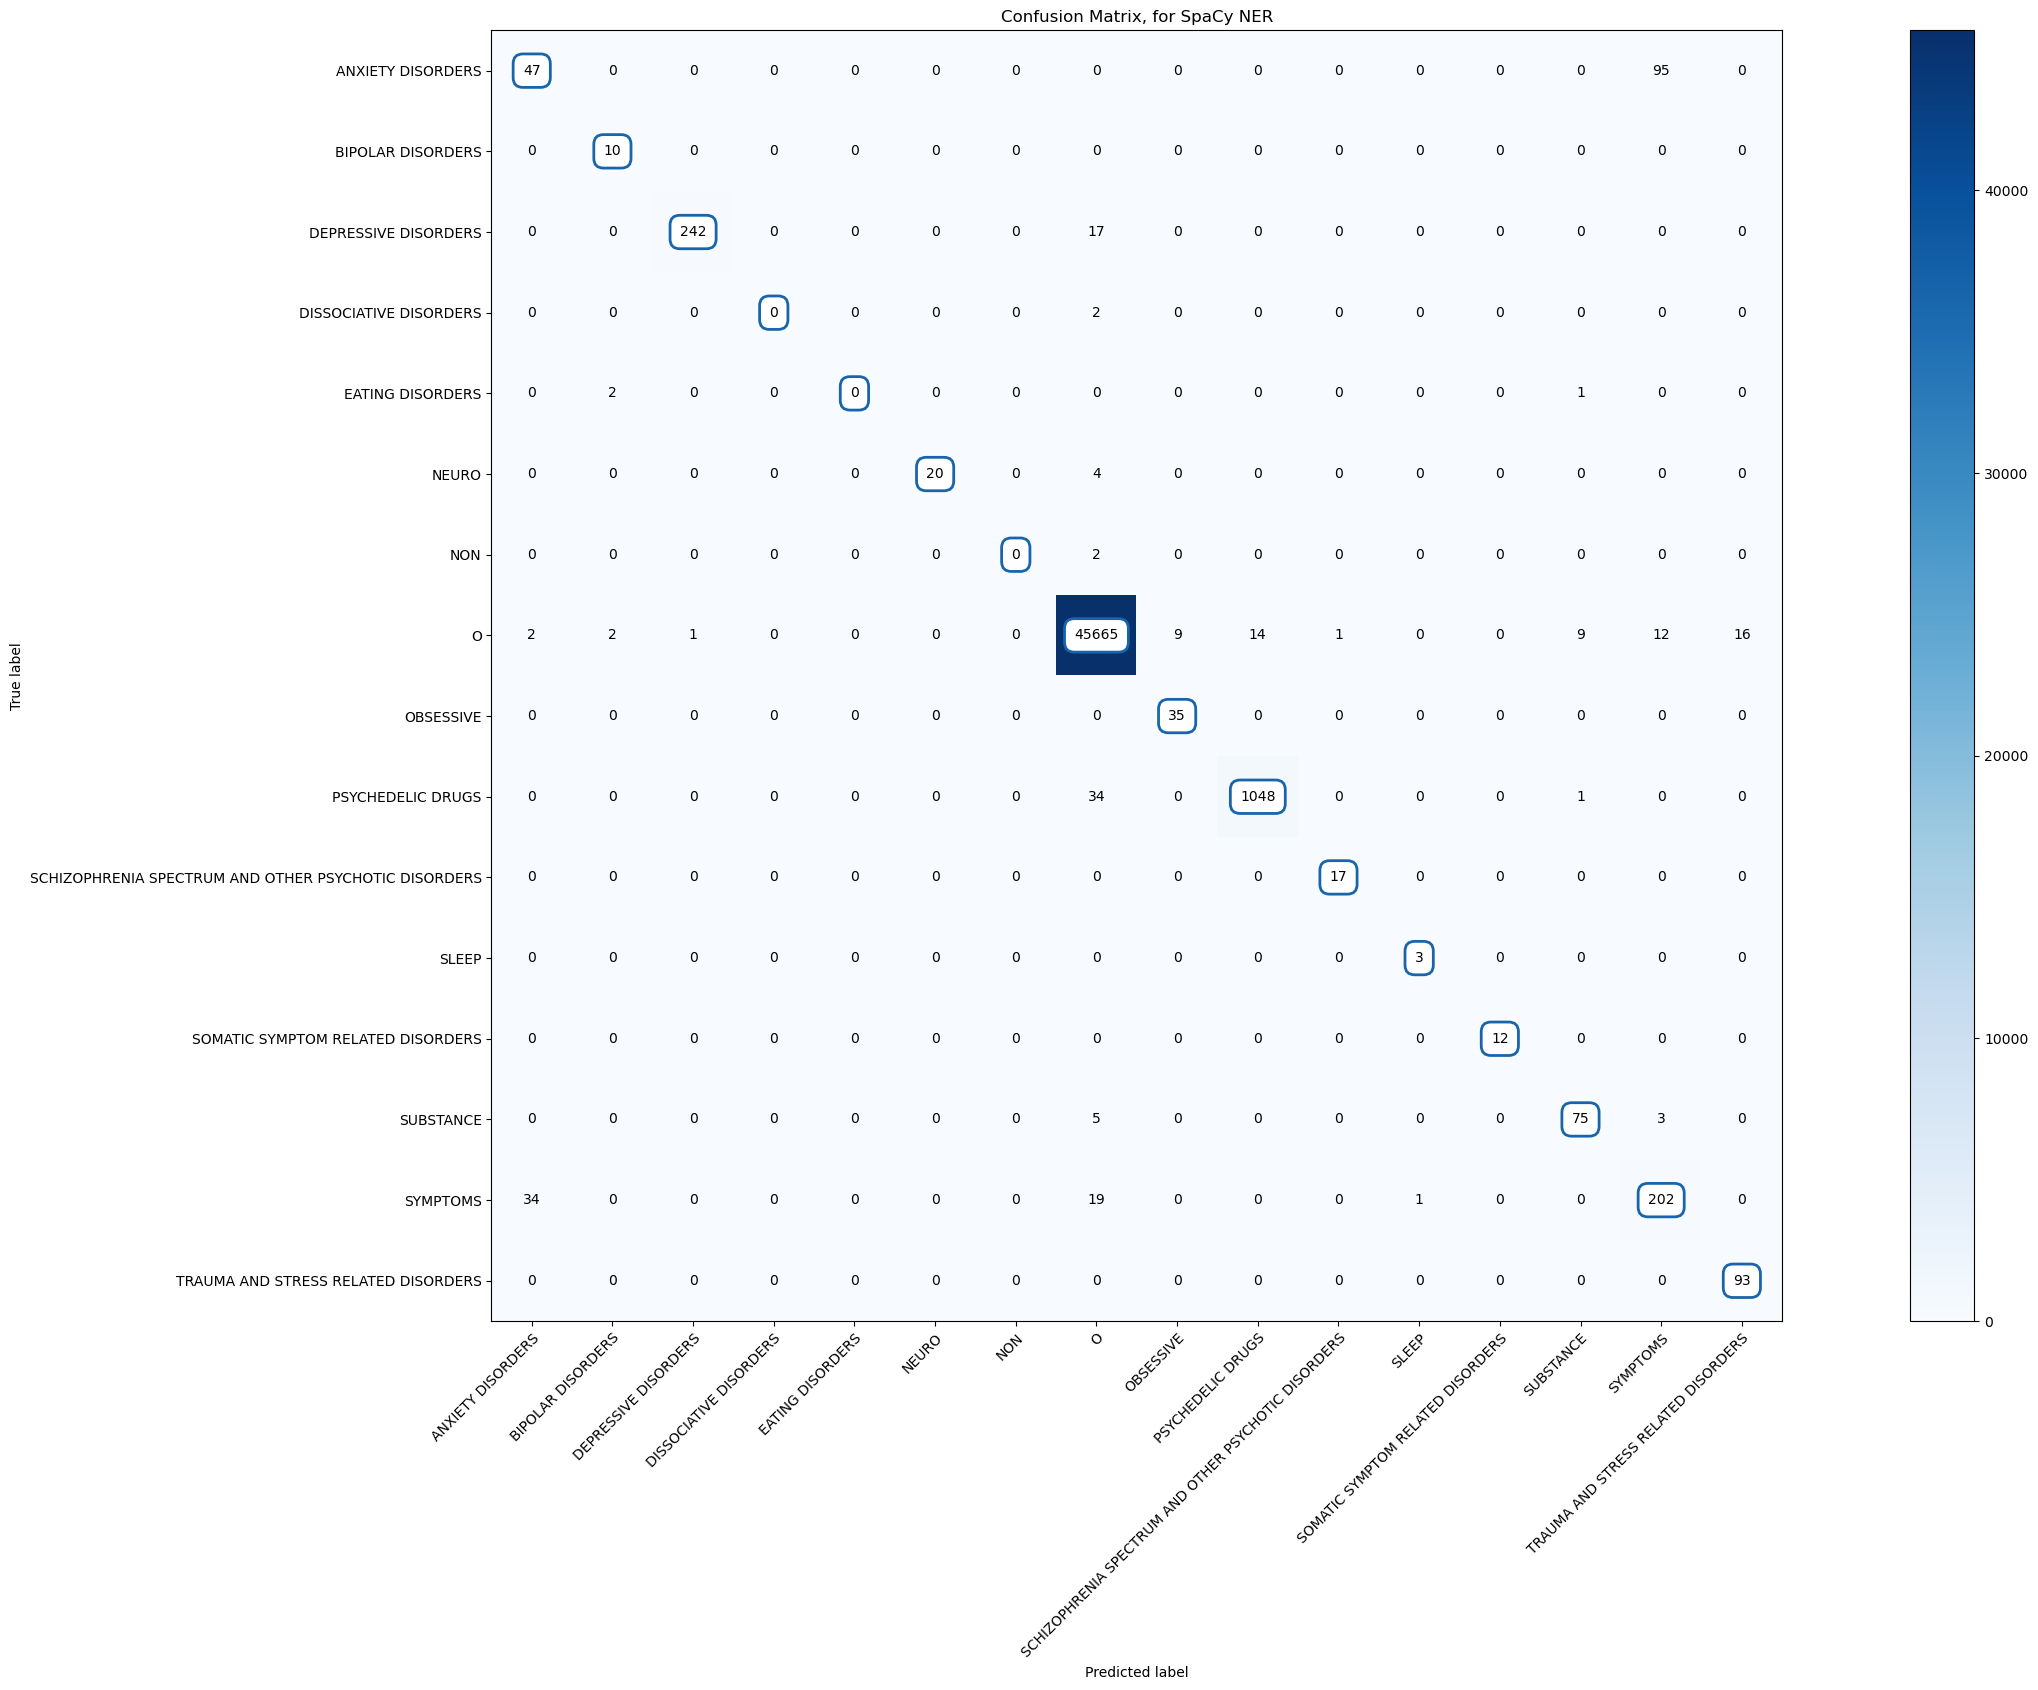

In [85]:
cm = ev.plot_confusion_matrix(nlp, docs, classes=get_dataset_labels(), normalize=False)